In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import sys
import scipy.io
sys.path.append("..")
import ODE_Dynamics as od
import Test_Likelihood as tl
import Positive_Symptom_fn as fn

In [2]:
data = scipy.io.loadmat('../data/test_data_simulation.mat')
x = tf.cast(data['data_simulation'],dtype = tf.float32)
test_data = np.reshape(
      x, x.shape)

In [3]:
test_data = tf.transpose(test_data)
print(test_data[:,0])

tf.Tensor(
[ 20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.
  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.
  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.
  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.
  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103.
 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117.
 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131.
 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145.
 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159.], shape=(140,), dtype=float32)


In [4]:
vdyn_ode_fn = od.ViralDynamics

In [5]:
#positive_fn = fn.proba_pos_sym(170306.4 * 1E-5).positive_fn
#symptom_fn = fn.proba_pos_sym(170306.4 * 1E-5).symptom_fn
positive_fn = fn.proba_pos_sym(0.0).positive_fn
symptom_fn = fn.proba_pos_sym(0.0).symptom_fn

In [6]:
prob_s_ibar = 0.1

In [16]:
loglike = tl.loglik(test_data, vdyn_ode_fn, positive_fn, symptom_fn, prob_s_ibar, prob_fp=0.0, Epi_Model=od.SIR,
                 duration=19.0, Epi_cadence=0.5, Vir_cadence=0.0625)

In [17]:
mu_b, sigma_b = 5, 1
beta = np.random.normal(mu_b, sigma_b, 1)
L = 0.0025/beta
V0 = np.random.normal(1E3, 1E2, 1)
print(V0)
X0 = 1E6
Y0 = V0
par=tf.constant(np.array([[L,0.01,beta*1E-7,0.5,20,10, V0, X0, Y0]], dtype=np.float32))
vpar = par
pospar = par
sympar = par

[912.04774251]


In [18]:
sample_size = 1000
k = 1
index = 1
mu_b, sigma_b = 5, 1
beta = np.random.normal(mu_b, sigma_b, 1)   #"rate at which virus infects host cells"
L = 0.0025/beta
par=np.array([[L,0.01,beta*1E-7,0.5,20.0,10.0]])
V0 = np.random.normal(1E3, 1E2, 1)
X0 = 1E6
Y0 = V0
init_state=(np.array([[V0,X0,Y0]], dtype=np.float32))

while index <= sample_size - 1:
    beta = np.random.normal(mu_b, sigma_b, 1)   #"rate at which virus infects host cells"
    L = 0.0025/beta
    par_new=np.array([[L,0.01,beta*1E-7,0.5,20.0,10.0]])
    par = np.concatenate((par, par_new), axis = 0)
    V0 = np.random.normal(1E3, 1E2, 1)
    X0 = 1E6
    Y0 = V0
    init_state_new=(np.array([[V0,X0,Y0]], dtype=np.float32))
    init_state = np.concatenate((init_state, init_state_new), 0)

    index +=1
        

vpar = tf.constant(par, dtype=tf.float32)
pospar = par
sympar = par

In [19]:
epipar = tf.constant(np.array([[1.8,  5.0E-08,0.1, 0.001,0.999]], dtype=np.float32))

In [20]:
ll,pp = loglike.__call__(test_data,epipar, vpar, pospar, sympar)

initial time
tf.Tensor(0.0, shape=(), dtype=float32)
final time
tf.Tensor(160.0, shape=(), dtype=float32)


In [21]:
C_xt = test_data[:,2]
N_xt = test_data[:,1]
pp_simu = C_xt/N_xt

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
plt.style.use('ggplot')
font = {'size'   : 9}
plt.rc('font', **font)

Text(0.5, 1, 'Test-positive probability likelihood function')

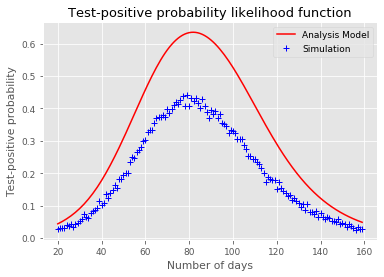

In [23]:
plt.plot(test_data[:,0], pp,"r-", label = "Analysis Model")
plt.plot(test_data[:,0], pp_simu, "b+", label = "Simulation")
plt.xlabel("Number of days")
plt.ylabel("Test-positive probability")
plt.legend(loc="upper right")
plt.savefig('simu_vs_code_psibar0.pdf', dpi=300, bbox_inches='tight')
plt.title("Test-positive probability likelihood function")

In [15]:
pp

<tf.Tensor: shape=(140,), dtype=float32, numpy=
array([0.04824407, 0.05198315, 0.05599104, 0.06028451, 0.06488071,
       0.06979707, 0.07505146, 0.08066159, 0.08664472, 0.09301818,
       0.09979823, 0.10700098, 0.11464115, 0.12273267, 0.13128856,
       0.14031853, 0.14983018, 0.15982907, 0.1703172 , 0.18129371,
       0.19274826, 0.2046536 , 0.21698481, 0.2297206 , 0.24284337,
       0.25633344, 0.27017137, 0.2843355 , 0.2988002 , 0.31353524,
       0.32850632, 0.34367406, 0.35899523, 0.37442106, 0.38989997,
       0.40537766, 0.4207953 , 0.43609548, 0.45121768, 0.46610382,
       0.48069647, 0.49495006, 0.5088156 , 0.5222433 , 0.53518224,
       0.5475855 , 0.559405  , 0.57059807, 0.5811255 , 0.5909521 ,
       0.6000566 , 0.6084214 , 0.6160319 , 0.62287664, 0.6289485 ,
       0.6342423 , 0.63875586, 0.64248806, 0.64544183, 0.6476193 ,
       0.6490263 , 0.64966923, 0.64955574, 0.6486949 , 0.6470991 ,
       0.64478105, 0.64175594, 0.6380423 , 0.63366   , 0.6286318 ,
       0.62297